<a href="https://colab.research.google.com/github/sallyMo14/Zillow_home_values_ts_forcasting/blob/main/Zillow_home_values_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom functions

In [ ]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax

In [ ]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error ,root_mean_squared_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = root_mean_squared_error(ts_true, ts_pred)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [ ]:
def get_sig_lags(ts, type='ACF',  nlags=None,alpha=0.5):


    if type == 'ACF':
        # Running the function used by plot_acf
        corr_values, conf_int = tsa.stattools.acf(ts, alpha=alpha, nlags=nlags)

    elif type=='PACF':
        corr_values, conf_int = tsa.stattools.pacf(ts, alpha=alpha, nlags=nlags)

    else:
        raise Exception("type must be either 'ACF' or 'PACF'")

    # Determine lags
    lags =range(len(corr_values))

    # Create a centered version of the acf_df
    corr_df = pd.DataFrame({type:corr_values,
                            'Lags':lags,
                            'lower ci': conf_int[:,0]-corr_values, # subtract acf from lower ci to center
                            'upper ci': conf_int[:,1]-corr_values, # subtact acf to upper ci to center
                                 })
    corr_df = corr_df.set_index("Lags")

    # Getting filter for sig lags
    filter_sig_lags = (corr_df[type] < corr_df['lower ci']) | (corr_df[type] > corr_df['upper ci'])

    # Get lag #'s
    sig_lags= corr_df.index[filter_sig_lags]
    sig_lags = sig_lags[sig_lags!=0]

    return sig_lags

In [ ]:
def plot_acf_pacf(ts, nlags=100, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)


    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags/2,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)




    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

# Imports

In [ ]:
!pip install numpy==1.26.4 pmdarima==2.0.4 --force-reinstall --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 177.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 163.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 199.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 173.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 193.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 138.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 158.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 150.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 173.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 147.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
import pandas as pd
# import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part one

In [ ]:
file_path="/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/06-AdvancedML/Week24/Data/zillow_home_values-zipcode.csv"
df=pd.read_csv(file_path)
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,...,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0,...,261945.0,267644.0,273946.0,280066.0,285121.0,288532.0,290458.0,291103.0,292081.0,292948.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0,...,453150.0,464727.0,478369.0,489712.0,497173.0,499429.0,497572.0,498113.0,500187.0,503109.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0,...,177319.0,179463.0,182812.0,186403.0,189836.0,192064.0,193760.0,195140.0,196787.0,198137.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0,...,570211.0,572145.0,573662.0,576469.0,578706.0,580834.0,581779.0,584566.0,588188.0,590722.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0,...,752025.0,757734.0,760336.0,766163.0,771443.0,776607.0,779281.0,782367.0,788211.0,793924.0


In [ ]:
melted = df.melt(id_vars=[	'RegionID',	'SizeRank',	'RegionName',	'RegionType',	'StateName',	'State',	'City',	'Metro',	'CountyName'] ,value_name='Home Value',var_name="Date")
melted.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,107261.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,222569.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,90009.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,188096.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,275983.0


In [ ]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7546550 entries, 0 to 7546549
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RegionID    int64  
 1   SizeRank    int64  
 2   RegionName  int64  
 3   RegionType  object 
 4   StateName   object 
 5   State       object 
 6   City        object 
 7   Metro       object 
 8   CountyName  object 
 9   Date        object 
 10  Home Value  float64
dtypes: float64(1), int64(3), object(7)
memory usage: 633.3+ MB


In [ ]:
melted.isna().sum()

,0
RegionID,0
SizeRank,0
RegionName,0
RegionType,0
StateName,0
State,0
City,381425
Metro,1645325
CountyName,0
Date,0


In [ ]:
melted['City']=melted['City'].fillna("Missing")
melted['Metro']=melted['Metro'].fillna("No metro")
melted['CountyName']=melted['CountyName'].fillna("Missing")
melted['Home Value']=melted['Home Value'].interpolate()


In [ ]:
melted.isna().sum()

,0
RegionID,0
SizeRank,0
RegionName,0
RegionType,0
StateName,0
State,0
City,0
Metro,0
CountyName,0
Date,0


In [ ]:
melted['Date']=pd.to_datetime(melted['Date'],format='%d%m%Y')
melted.set_index('Date',inplace=True)


In [ ]:
melted.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,91940,0,77449,zip,TX,TX,Missing,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0
2000-01-31,91982,1,77494,zip,TX,TX,Missing,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0
2000-01-31,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0
2000-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0
2000-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0


In [ ]:
melted.tail()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2022-11-30,80190,30657,50160,zip,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,193591.0
2022-11-30,65355,30657,18081,zip,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,376523.0
2022-11-30,82217,30657,55366,zip,MN,MN,Missing,No metro,Sibley County,110082.0
2022-11-30,80581,30657,51009,zip,IA,IA,Calumet,No metro,O Brien County,75810.0
2022-11-30,65963,30657,19490,zip,PA,PA,Collegeville,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Montgomery County,623590.0


In [ ]:
tableau_df=melted.copy()

In [ ]:
tableau_df=tableau_df.loc[tableau_df['State'].isin(['CA', 'WA', 'OR', 'AZ', 'NV'])]


In [ ]:
tableau_df['State'].unique()

array(['CA', 'WA', 'AZ', 'NV', 'OR'], dtype=object)

In [ ]:
tableau_df=tableau_df.loc['2010':'2020']

In [ ]:
tableau_df.isna().sum()

,0
RegionID,0
SizeRank,0
RegionName,0
RegionType,0
StateName,0
State,0
City,0
Metro,0
CountyName,0
Home Value,0


In [ ]:
filename = 'data-for-tableau.csv'

df.to_csv('/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/06-AdvancedML/Week24/Data/' + filename)

In [ ]:
tableau_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2010-01-31,95992,5,90011,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,209250.0
2010-01-31,96361,8,91331,zip,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,257372.0
2010-01-31,96193,9,90650,zip,CA,CA,Norwalk,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,296430.0
2010-01-31,96083,12,90201,zip,CA,CA,Bell,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,271829.0
2010-01-31,96816,13,92335,zip,CA,CA,Fontana,"Riverside-San Bernardino-Ontario, CA",San Bernardino County,156704.0


In [ ]:
ts=tableau_df[['State','Home Value']]
ts.head()

,State,Home Value
Date,,
2010-01-31,CA,209250.0
2010-01-31,CA,257372.0
2010-01-31,CA,296430.0
2010-01-31,CA,271829.0
2010-01-31,CA,156704.0


In [ ]:
yearly = ts.groupby("State").resample("Y", level="Date").mean()

yearly

/tmp/ipython-input-3211205055.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = ts.groupby("State").resample("Y", level="Date").mean()


Home Value
State Date                     
AZ    2010-12-31  172613.279503
      2011-12-31  155772.308064
      2012-12-31  161405.605724
      2013-12-31  183865.378258
      2014-12-31  198030.809999
      2015-12-31  205267.393269
      2016-12-31  215361.572581
      2017-12-31  226031.501406
      2018-12-31  241555.022283
      2019-12-31  254098.593847
      2020-12-31  275843.772413
CA    2010-12-31  394222.835315
      2011-12-31  370228.983798
      2012-12-31  371965.191533
      2013-12-31  436260.934329
      2014-12-31  486457.070699
      2015-12-31  515364.396921
      2016-12-31  550887.463734
      2017-12-31  584076.619716
      2018-12-31  632159.035896
      2019-12-31  635555.597093
      2020-12-31  662364.643943
NV    2010-12-31  184380.899013
      2011-12-31  166294.009096
      2012-12-31  161650.174596
      2013-12-31  193590.511272
      2014-12-31  220395.396739
      2015-12-31  236933.728127
      2016-12-31  253468.863345
      2017-12-31  272513.665793
      2018-12-31  306296.736500
      2019-12-31  323623.762723
      2020-12-31  335909.745581
OR    2010-12-31  218614.823256
      2011-12-31  201673.641774
      2012-12-31  197694.114111
      2013-12-31  212084.951466
      2014-12-31  227801.232801
      2015-12-31  244011.878280
      2016-12-31  266206.678984
      2017-12-31  287079.428291
      2018-12-31  305448.393626
      2019-12-31  318084.143379
      2020-12-31  334586.221842
WA    2010-12-31  237272.564997
      2011-12-31  220121.222461
      2012-12-31  217352.497808
      2013-12-31  232601.577708
      2014-12-31  248432.429898
      2015-12-31  267911.640570
      2016-12-31  293616.301002
      2017-12-31  324875.487072
      2018-12-31  356444.943213
      2019-12-31  370906.244539
      2020-12-31  398021.431254

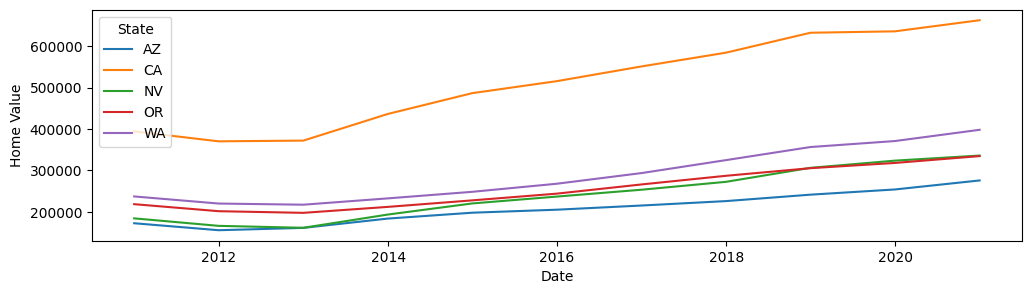

In [ ]:
sns.lineplot(data=yearly, x="Date", y="Home Value", hue="State")
plt.show()

# Part tow

## Prepare fpr modeling

In [ ]:
melted.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,91940,0,77449,zip,TX,TX,Missing,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0
2000-01-31,91982,1,77494,zip,TX,TX,Missing,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0
2000-01-31,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0
2000-01-31,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0
2000-01-31,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0


In [ ]:
melted.isna().sum()

,0
RegionID,0
SizeRank,0
RegionName,0
RegionType,0
StateName,0
State,0
City,0
Metro,0
CountyName,0
Home Value,0


In [ ]:
melted_df=melted.copy()

In [ ]:
melted_df=melted_df.loc[melted_df['State']=="OR"]


In [ ]:
print(melted_df.index.to_series().diff().value_counts())


Date
0 days     100100
31 days       159
30 days        92
28 days        17
29 days         6
Name: count, dtype: int64


* just to ensure the ts frequency is monthly

In [ ]:
melted_df_00_18=melted_df.loc['2000-01-31':'2018-12-31']
melted_df_00_18

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,99142,262,97229,zip,OR,OR,Portland,"Portland-Vancouver-Hillsboro, OR-WA",Washington County,260209.0
2000-01-31,99178,489,97301,zip,OR,OR,Salem,"Salem, OR",Marion County,109851.0
2000-01-31,99048,528,97045,zip,OR,OR,Oregon City,"Portland-Vancouver-Hillsboro, OR-WA",Clackamas County,204570.0
2000-01-31,99093,549,97124,zip,OR,OR,Hillsboro,"Portland-Vancouver-Hillsboro, OR-WA",Washington County,181574.0
2000-01-31,99252,656,97402,zip,OR,OR,Eugene,"Eugene-Springfield, OR",Lane County,136799.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31,99279,30657,97432,zip,OR,OR,Winston,"Roseburg, OR",Douglas County,163902.0
2018-12-31,99025,30657,97020,zip,OR,OR,Donald,"Salem, OR",Marion County,327667.0
2018-12-31,99101,30657,97134,zip,OR,OR,Tillamook,No metro,Tillamook County,397175.0


In [ ]:
melted_ts_00_18=melted_df_00_18[['Home Value']]
melted_ts_00_18

,Home Value
Date,
2000-01-31,260209.0
2000-01-31,109851.0
2000-01-31,204570.0
2000-01-31,181574.0
2000-01-31,136799.0
...,...
2018-12-31,163902.0
2018-12-31,327667.0
2018-12-31,397175.0


In [ ]:
melted_ts_00_18=melted_ts_00_18.groupby(melted_ts_00_18.index).mean()

In [ ]:
melted_ts_00_18.head()

,Home Value
Date,
2000-01-31,153060.654002
2000-02-29,153432.423944
2000-03-31,153435.477724
2000-04-30,154292.227334
2000-05-31,158554.325116


In [ ]:
melted_ts_00_18.isna().sum()

,0
Home Value,0


### Check for seasonality

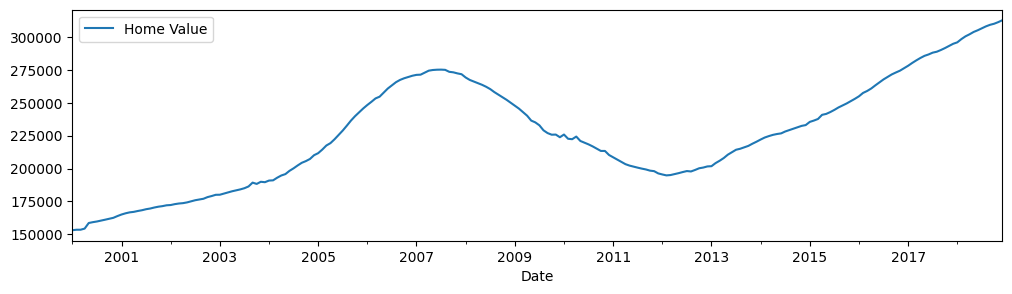

In [ ]:
ax = melted_ts_00_18.plot()

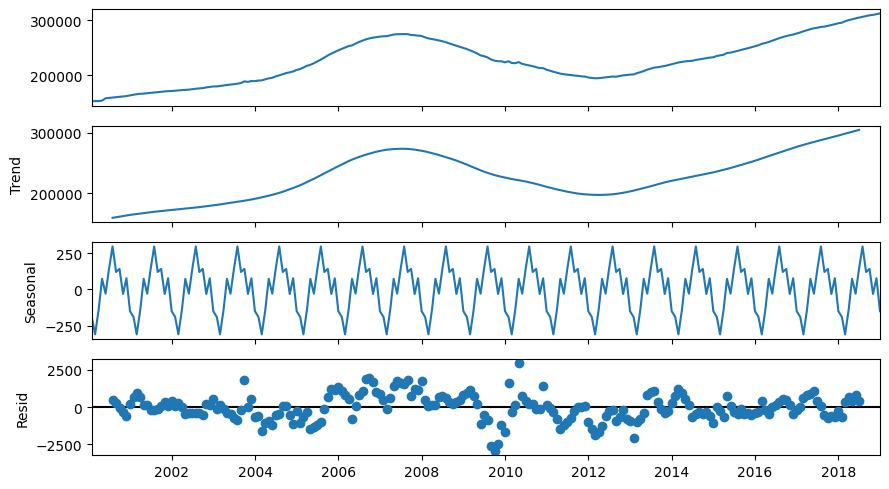

In [ ]:
## Use Seasonal Decompose to check for seasonality
decomp = tsa.seasonal_decompose(melted_ts_00_18)
fig = decomp.plot()
fig.set_size_inches(9, 5)
fig.tight_layout()

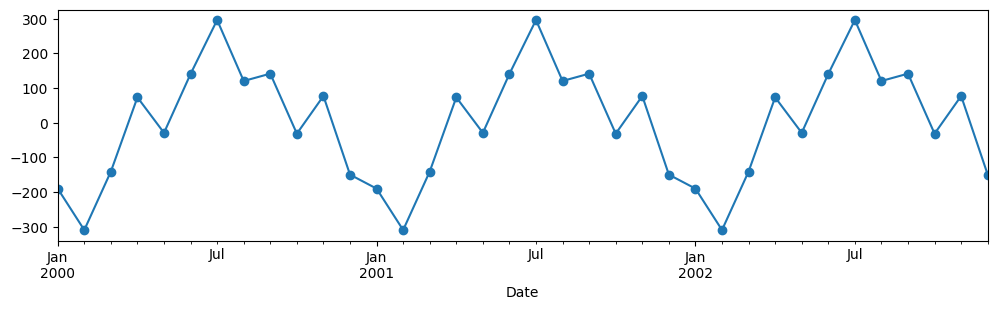

In [ ]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['2000': '2002'].plot(marker = 'o')

In [ ]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts['Home Value'].max()-ts['Home Value'].min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 606.0069195244869 which is ~0.01% of the variation in time series.


* the seasonality component is very weak , so there is no sesonality

### Check if stationary

In [ ]:
# Check for stationarity
get_adfuller_results(melted_ts_00_18)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.71061,3,224,0.425654,0.05,False


* Time series is not stationary

### Determine diff

In [ ]:
# Determine differencing
d = ndiffs(melted_ts_00_18)
print(f'd is {d}')

d is 2


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

* **d = 2**
* we nedd to do 2 diffs to make the time series stationary

In [ ]:
ts_diff = melted_ts_00_18.diff().diff().dropna()

In [ ]:
# Check for stationarity
get_adfuller_results(ts_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-19.482427,1,224,0.0,0.05,True


### Determine the model type and order

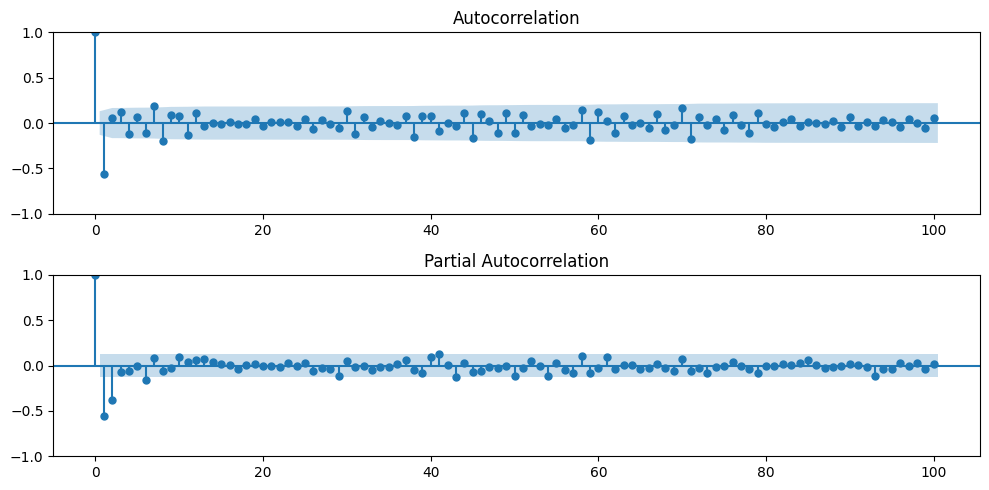

In [ ]:
plot_acf_pacf(ts_diff);

* Both acf and pcf are gradually decreasing , so we will use ARIMA model and start with order p=1 , q=1

## Modeling

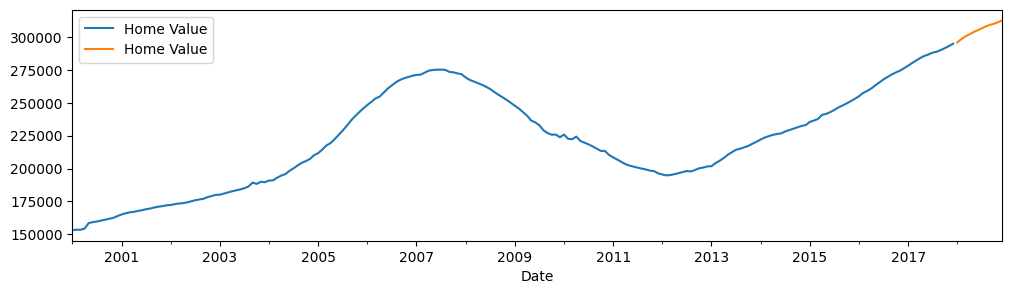

In [ ]:
from pmdarima.model_selection import train_test_split
# train, test = train_test_split(melted_ts_00_18, test_size=0.053)
train = melted_ts_00_18.loc[:'2017-12-31']
test =melted_ts_00_18.loc['2018-01-31':'2018-12-31']
## Visualize train-test-split
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [ ]:
len(test)

12

* because we want to forcast 12 months , we should mimic the len of the test data and the period we want to forcast home values in


In [ ]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 2  # nonseasonal differencing
q = 1 # nonseasonal MA
arima = tsa.ARIMA(train, order = (p,d,q)).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [ ]:
# Obtain summary
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Home Value   No. Observations:                  216
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1798.834
Date:                Fri, 19 Sep 2025   AIC                           3603.667
Time:                        22:47:44   BIC                           3613.765
Sample:                    01-31-2000   HQIC                          3607.748
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5439      0.113      4.826      0.000       0.323       0.765
ma.L1         -0.5931      0.114     -5.221      0.000      -0.816      -0.370
sigma2      1.155e+06   5.59e+04     20.684      0.000    1.05e+06    1.26e+06
===================================================================================
Ljung-Box (L1) (Q):                  62.92   Jarque-Bera (JB):               360.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

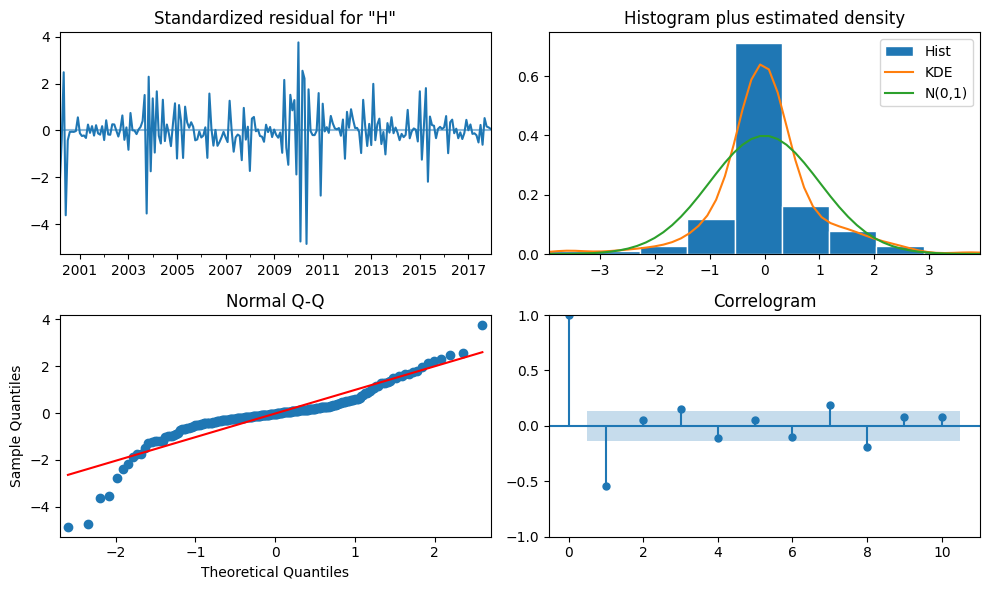

In [ ]:
# Obtain diagnostic plots
fig = arima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

* The variation of Standardized residuals values is not constant
* The histogram plus estimated density is not normally distributed
* there is a significant value in the correlogram of the residuals at lag 1 , 3, 4 ,7 ,8  indicates this model may have missed.


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 715.174
- MSE = 741,154.173
- RMSE = 860.903
- R^2 = 0.971
- MAPE = 0.23%


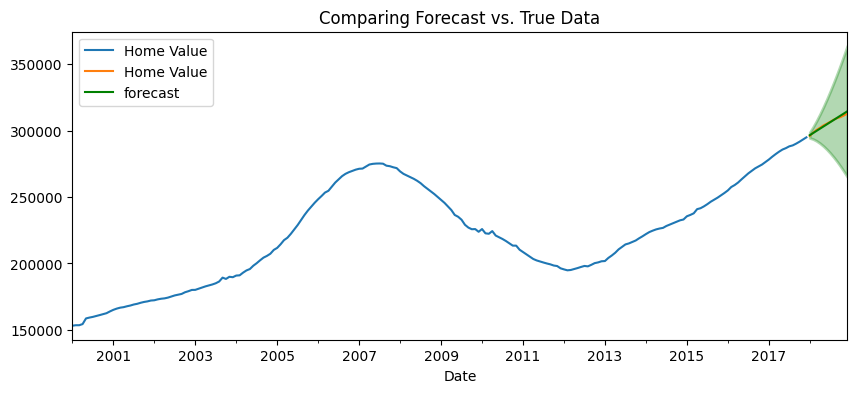

In [ ]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = arima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

* value of R2=0.982 is bretty good
* RMSE=756 , MAE=690 are reasonable errors for monthly home values mean
* The forcast line is almost typical as the test plot

## Tunning

In [ ]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    trace=True
)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3606.133, Time=1.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3606.100, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3619.703, Time=0.05 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3605.402, Time=0.13 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3603.667, Time=0.22 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3604.964, Time=0.36 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3604.416, Time=0.42 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=3604.374, Time=0.19 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(0,0,0)[0]             : AIC=3604.833, Time=0.13 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=3605.641, Time=0.40 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 3.240 seconds


In [ ]:
print(auto_model.order)

(1, 2, 1)


* So the auto_arima tuning obtains the best model which is ARIMA(1,2,1) , and this is the model that we start with
➡So we will use the same model for forcasting

## Train the selected model for all the time series

In [ ]:
final_model=tsa.ARIMA(melted_ts_00_18, order = (1,2,1)).fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [ ]:
# Obtain summary
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Home Value   No. Observations:                  228
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1896.846
Date:                Fri, 19 Sep 2025   AIC                           3799.693
Time:                        22:48:17   BIC                           3809.954
Sample:                    01-31-2000   HQIC                          3803.834
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9931      0.011    -89.065      0.000      -1.015      -0.971
ma.L1          0.9911      0.013     77.887      0.000       0.966       1.016
sigma2      1.143e+06   7.95e-10   1.44e+15      0.000    1.14e+06    1.14e+06
===================================================================================
Ljung-Box (L1) (Q):                  69.63   Jarque-Bera (JB):               430.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.26e+30. Standard errors may be unstable.
"""

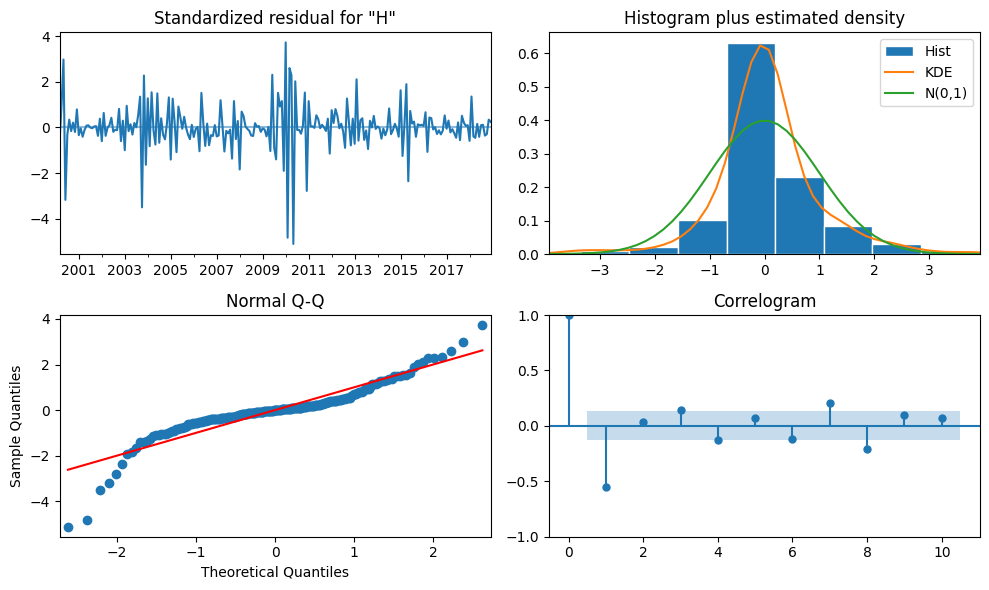

In [ ]:
# Obtain diagnostic plots
fig =final_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

* same interpretation of arima model diagnostics

## Forcasting

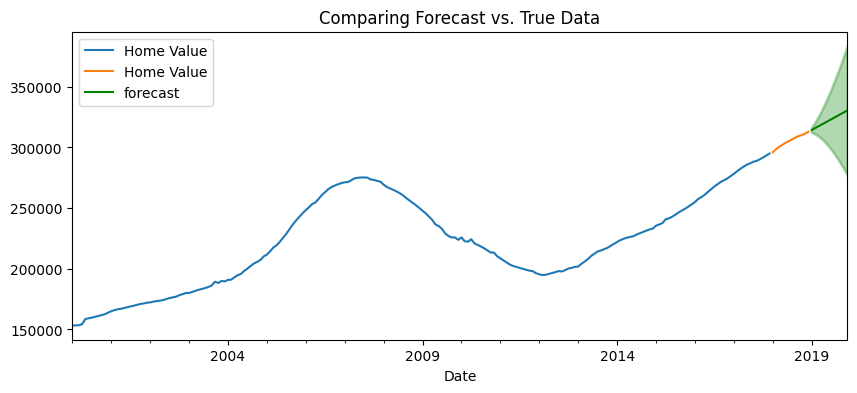

In [ ]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = final_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);

In [ ]:
forecast_df

Home Value,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-01-31,314369.638377,1068.979025,312274.477989,316464.798765
2019-02-28,315812.670235,2388.391345,311131.509219,320493.831252
2019-03-31,317301.378051,3996.875033,309467.646936,325135.109167
2019-04-30,318744.725490,5849.939948,307279.053879,330210.397101
2019-05-31,320233.119906,7921.082215,304708.084045,335758.155767
2019-06-30,321676.778579,10188.170253,301708.331816,341645.225343
2019-07-31,323164.863911,12637.047847,298396.705261,347933.022562
2019-08-31,324608.829533,15253.921491,294711.692787,354505.966279
2019-09-30,326096.610037,18029.863458,290758.727014,361434.493061
2019-10-31,327540.878381,20955.151664,286469.535828,368612.220933


In [ ]:
final_value = forecast_df['mean'].iloc[-1]
final_value

330472.92515122093

In [ ]:
# Define starting and final values
starting_value = forecast_df['mean'].iloc[0]
final_value = forecast_df['mean'].iloc[-1]
# Change in x
delta = final_value - starting_value
print(f'The change in X over the forecast is {delta: .2f}.')
perc_change = (delta/starting_value) *100
print (f'The percentage change is {perc_change :.2f}%.')

The change in X over the forecast is  16103.29.
The percentage change is 5.12%.


In [ ]:
starting_value


314369.6383768838

The model predicts the cummulative home values means after 12 months beyond the data (by the end of Dec 2019) to be **~ 330500** , and represents **5.12%** increase comparing to the start of the forcast period (Jan 2019) (~ 314000)